# Traveling Salesman Problem
In this assignment, we’ll be using a Genetic Algorithm to find a solution to the traveling salesman problem (TSP). The TSP is described as follows:
“Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?”
![picture](https://drive.google.com/uc?export=view&id=1TdAXs4W-Ms_tUAoo1xr4IAwieJ6PkIon)
Illustration of a potential solution to the Traveling Salesman Problem.

Given this, there are two **important rules** to keep in mind:
- Each city needs to be visited exactly one time
- We must return to the starting city, so our total distance needs to be calculated accordingly  
## Approach:  
Let’s start with a few definitions, rephrased in the context of the TSP:
- Gene: a city (represented as (x, y) coordinates)
- Individual (aka “chromosome”): a single route satisfying the conditions above
- Population: a collection of possible routes (i.e., collection of individuals)
- Parents: two routes that are combined to create a new route
- Mating pool: a collection of parents that are used to create our next population (thus creating the next generation of routes)
- Fitness: a function that tells us how good each route is (in our case, how short the distance is)
- Mutation: a way to introduce variation in our population by randomly swapping two cities in a route
- Elitism: a way to carry the best individuals into the next generation    
  
Our GA will proceed in the following steps:
- 1. Create the population
- 2. Determine fitness
- 3. Select the mating pool
- 4. Breed
- 5. Mutate
- 6. Repeat  
Now, let’s see this in action.

## Create necessary classes and functions

Create two classes: City and Fitness  
We first create a City class that will allow us to create and handle our cities. These are simply our (x, y) coordinates. Within the City class, we add a distance calculation (making use of the Pythagorean theorem) in line 6 and a cleaner way to output the cities as coordinates with `__repr __`.

Create class to handle "cities"

In [215]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

In [216]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

We’ll also create a Fitness class. In our case, we’ll treat the fitness as the inverse of the route distance. We want to minimize route distance, so a larger fitness score is better. Based on Rule #2, we need to start and end at the same place, so this extra calculation is accounted for in line 13  
`(if i + 1 < len(self.route))`  
of the distance calculation.

In [217]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

## Create our initial population

Route generator.  
We now can make our initial population (aka first generation). To do so, we need a way to create a function that produces routes that satisfy our conditions (Note: we’ll create our list of cities when we actually run the GA at the end of the tutorial). To create an individual, we randomly select the order in which we visit each city:

In [218]:
def createRoute(cityList):
    """
    Creates a random individual.
    
    input: None
    output: A list of City class objects. 
    """
    route = random.sample(cityList, len(cityList))
    return route

Create first "population" (list of routes)  
This produces one individual, but we want a full population, so let’s do that in our next function. This is as simple as looping through the createRoute function until we have as many routes as we want for our population.

In [219]:
def initialPopulation(popSize, cityList):
    """
    Create inital population of a given size.
    Returns a list of random planes
    """
    population = []

    for i in range(popSize):
        population.append(createRoute(cityList))
    return population

Note: we only have to use these functions to create the initial population. Subsequent generations will be produced through breeding and mutation.

## Create the genetic algorithm - Determine Fitness

Rank individuals  
Next, the evolutionary fun begins. To simulate our “survival of the fittest”, we can make use of Fitness to rank each individual in the population. Our output will be an ordered list with the route IDs and each associated fitness score.

In [220]:
def rankRoutes(population):
    """
    This function sorts the given population in decreasing order of the fitness score.
    Returns a list of ordered pairs of (index, fitness) where index is the index of the
    individual within the population
    """
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

## Select the mating pool
There are a few options for how to select the parents that will be used to create the next generation. The most common approaches are either fitness proportionate selection (aka “roulette wheel selection”) or tournament selection:
- Fitness proportionate selection: The fitness of each individual relative to the population is used to assign a probability of selection. Think of this as the fitness-weighted probability of being selected.
- Tournament selection: A set number of individuals are randomly selected from the population and the one with the highest fitness in the group is chosen as the first parent. This is repeated to chose the second parent.  

Another design feature to consider is the use of elitism. With elitism, the best performing individuals from the population will automatically carry over to the next generation, ensuring that the most successful individuals persist.  



**Algorithm for weighted random number selection:** Say we have an array of weights $W$, $w_{i}$ is the weight that is proportional to the probability of selecting number $i$. First, we need to find the prefix sum $p$ of each number.($p_{k}$ = sum of all the weights from i= 0 to i= k) $$ p_{k} = \sum_{i=0}^{i=k} w_{i}$$
Next, we randomly select a value between 0 and the largest prefix sum (the prefix sum of the last individual, which is also the sum of all weights). To return the selected number, we find the smallest index that corresponds to the prefix sum greater than the randomly chosen value.

**To-do** (1.1)
1. Implement `selection`. (4 points)

In [221]:
def selection(popRanked, eliteSize):
    """
    popRanked: output of rankRoutes()
    eliteSize: number of highest ranked individuals we will retain in the next generation.
    
    This function takes in a population sorted in decreasing order of fitness score, and chooses a mating pool from it.
    It returns a list of indices of the chosen mating pool in the given population.
    """
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked[eliteSize:]), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = df.cum_sum/df.Fitness.sum()
    ### Retaining the best individual in the population. 
    for i in range(eliteSize):
        selectionResults.append(popRanked[i][0])
    # weighted random selection
    for i in range(eliteSize, len(popRanked)):
        pick = random.random()
        for j in range(len(popRanked)-eliteSize):
            if pick <= df.iat[j,3]:
                selectionResults.append(int(df.iat[j,0]))
                break
    return selectionResults
    #YOUR CODE HERE

Now that we have the IDs of the routes that will make up our mating pool from the selection function, we can create the mating pool. We’re simply extracting the selected individuals from our population.

**To-do** (1.2)
1. Implement `matingPool`. (1 points)

In [222]:
def matingPool(population, selectionResults):
    """
    This function takes in a population and returns the chosen mating pool, or a list of routes. 
    """
    pool_list = []
    for i in selectionResults:
        pool_list.append(population[i])
    return pool_list
    #YOUR CODE HERE 
    

## Breed
With our mating pool created, we can create the next generation in a process called crossover (aka “breeding”). In the GA perceptron problem, individuals were vectors of weights and bias, we could simply pick a crossover point and splice the two lists together to produce an offspring.  
However, the TSP is unique in that we need to include all locations exactly one time. To abide by this rule, we can use a special breeding function called ordered crossover. In ordered crossover, we randomly select a subset of the first parent string and then fill the remainder of the route with the genes from the second parent in the order in which they appear, without duplicating any gene positions from the first parent's selected subset. 


![picture](https://drive.google.com/uc?export=view&id=1EnVVFtafYwaTaNkyFTKHTlxV49ufCwfB)

**To-do** (1.3) (6 points)
1. Implement `breed`. (3 points)
2. Implement `breedPopulation`. (3 points)

In [232]:
def breed(parent1, parent2):
    """
    This function should breed both parents (routes) and return a child route according to the ordered crossover algorithm  
    mentioned above. Please fill in the code to do so.
    """
    child = [-1] * len(parent1)
    
    subset_start, subset_end = sorted(random.sample(range(len(parent1) + 1), 2))
    
    child_inherited = []

    for i in range(subset_start, subset_end):
        child[i] = parent1[i]
        child_inherited.append(parent1[i])
        
    parent1_position, parent2_position = 0, 0
    
    position = list(range(subset_start, subset_end))       
    i = 0
    while i < len(parent1):
        if i in position:
            i += 1
            continue
        test_child = child[i]
        if test_child==-1:
            parent2_trait = parent2[parent2_position]
            while parent2_trait in child_inherited:
                parent2_position += 1
                parent2_trait = parent2[parent2_position]
            child[i] = parent2_trait
            child_inherited.append(parent2_trait)
        i +=1
    
    return child
    #YOUR CODE HERE

Next, we’ll generalize this to create our offspring population. 

In [224]:
def breedPopulation(matingpool,eliteSize):
    """
    This function should return the offspring population from the current population using the breed function. It should 
    retain the eliteSize best routes from the current population. Then it should use the breed function to mate
    members of the population, to fill out the rest of the next generation. 
    You have the freedom to decide how to choose mates for individuals.
    """
    pairs_needed = len(matingpool) - eliteSize
    children = []
    for i in range(eliteSize + 1):
        children.append(matingpool[i])
    
    for i in range(pairs_needed):
        parent1 = random.choice(matingpool)
        parent2 = random.choice(matingpool)
        children.append(breed(parent1, parent2))
    
    return children
    #YOUR CODE HERE

## Mutate
Mutation serves an important function in GA, as it helps to avoid local convergence by introducing novel routes that will allow us to explore other parts of the solution space. Similar to crossover, the TSP has a special consideration when it comes to mutation. 

Since we need to abide by our rules, we can’t drop cities, and we can use swap mutation. This means that, with specified low probability, two or more cities will swap places in our route. We’ll do this for one individual in our mutate function. Each individual in the population has a chance to be mutate with probability mutationRate.

**To-do**: (1.4)
1. Impletement `mutate` and `mutatePopulation`.(3 points)

In [225]:
def mutate(individual, mutationRate):
    """
    This function should take in an individual (route) and return a mutated individual. Assume mutationRate is a probability
    between 0 and 1. Use the swap mutation described above to mutate the individual according to the mutationRate. Iterate 
    through each of the cities and swap it with another city according to the given probability.
    """
    for i in range(len(individual)):
        if np.random.random() <= mutationRate:
            swap_index = np.random.randint(0, len(individual))
            placeholder = individual[i]
            individual[i] = individual[swap_index]
            individual[swap_index] = placeholder
    return individual
    #YOUR CODE HERE

Next, we can extend the mutate function to run through the new population.  
Please create a function to run mutation over entire population (except for the elites) and return the new population. The top eliteSize members of the previous population should not be mutated. Each member of the population is mutated with probability mutationRate.

In [239]:
def mutatePopulation(population,mutationRate):
    """
    This function should use the above mutate function to mutate each member of the population. Simply iterate over the 
    population and mutate each individual using the mutationRate.
    """
    mutatedPop = []
    for i in population:
        mutatedPop.append(mutate(i, mutationRate))
    return mutatedPop
    #YOUR CODE HERE

## Repeat
We’re almost there. Let’s pull these pieces together to create a function that produces a new generation. First, we rank the routes in the current generation using `rankRoutes`. We then determine our potential parents by running the `selection` function, which allows us to create the mating pool using the `matingPool` function. Finally, we then create our new generation using the `breedPopulation` function and then applying mutation using the `mutatePopulation` function.

**To-do**: (1.5)

Impletement `nextGeneration`.(3 points)

In [235]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    """
    This function takes in the current generation, eliteSize and mutationRate and should return the next generation.
    Please use all the above defined functions to do so, some hints are in the above paragraph.
    """
    ranked_pop = rankRoutes(currentGen)
    selected = selection(ranked_pop, eliteSize)
    pool = matingPool(currentGen, selected)
    bred_pop = breedPopulation(pool, eliteSize)
    nextGeneration = mutatePopulation(bred_pop, mutationRate)

    return nextGeneration
    #YOUR CODE HERE

## Final step: Evolution in motion
We finally have all the pieces in place to create our GA! All we need to do is create the initial population, and then we can loop through as many generations as we desire. Of course we also want to see the best route and how much we’ve improved, so we capture the initial distance in line 3 (remember, distance is the inverse of the fitness), the final distance, and the best route.  


**To-do**: (1.6)

Implement `geneticAlgorithm` with two stopping mechanisms. One: The algorithm should stop running when the maximum number of generations is reached. Two, stop when the highest fitness from the population hasn't increased for a set number of generations.(This means the algorithm to some extent has converged).  (5 points)

The inputs:
1. `population` : A list of possible genes. In our case, a list of all `City`s. 
2. `popSize`: The population size at each generation. 
3. `eliteSize`: The size of the elite population. 
4. `mutationRate`: The probabilty of an individual gets mutated. 
4. `generations`: The maxmium number of generations to run for. 
5. `max_num_gen_no_improv`: The maxmium number of generations with no improvement is allowed before we stop the algorithm early. 

The outputs:
1. `bestRoute`: The route with the highest fitness score(`bestRoute_list[-1]`). 
2. `bestRoute_list` : A list of best routes. `bestRoute_list[0]` is the best route from the first generation of population, `bestRoute_list[2]` is the bestRoute from the second generation of population and so on. 
3. `fitness_record`: A list of the best fitness from each generation. `fitness_record[0]` is the best fitness score from the first generation. 

Advice for debugging:

First, I recommend checking the size of your population in every generation. Your algorthm will not run correctly if the population size changes between generations. Second, plot the `fitness_record` and see if it is increasing monotonically, or the elite population has not been retained properly. 

In [241]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations, max_num_gen_no_improv):
    """
    This function creates an initial population, then runs the genetic algorithm according to the given parameters. 
    """
    pop = initialPopulation(popSize, population)
    init_rank = rankRoutes(pop)
    print("Initial distance: " + str(1 / init_rank[0][1]))
    fitness_record = [init_rank[0][1]]
    bestRoute_list = [pop[init_rank[0][0]]]
    
    for i in range(generations):
        if len(fitness_record) >= max_num_gen_no_improv and fitness_record[-1] == fitness_record[0 - max_num_gen_no_improv]:
            break
        pop = nextGeneration(pop, eliteSize, mutationRate)
        pop_rank = rankRoutes(pop)
        fitness_record.append(pop_rank[0][1])
        bestRoute_list.append(pop[pop_rank[0][0]])
    
    bestRoute = bestRoute_list[-1]
    
    print("Final distance: " + str(1 / fitness_record[-1]))
    return bestRoute, bestRoute_list, fitness_record
    #YOUR CODE HERE

## Running the genetic algorithm

With everything in place, solving the TSP is as easy as two steps:  
First, we need a list of cities to travel between. For this demonstration, we’ll use the list of 99 biggest cities (excluding Honolulu) of United States (brute force would have to test over $10^{153}$ routes!):
![picture](https://drive.google.com/uc?export=view&id=1csbL4ncv_62nab477F9ifPslx3K13bfJ)

## Create the City list
You need to put all the 99 cities as city objects in the cityList array. We will use the last column Coordinates to calculate the distance between all the cities. And for convenience we will multiply all the coordinates by 100. For example, for New York, it would be  
NewYork= City( int(40.71 * 100), int( -74.00 * 100))  
And then you can put `cityList.append(NewYork)`

Here is the sample code of calculating the path to travel top 5 cities of U.S.

In [237]:
cityList = []
NewYork= City( int(40.71 * 100), int( -74.00 * 100)) 
LA= City(3405,-11824) 
Chicago=City(4187,-8762)
Houston=City(2976,-9536)
Philly=City(3995,-7516)
cityList.append(NewYork)
cityList.append(LA)
cityList.append(Chicago)
cityList.append(Houston)
cityList.append(Philly)

Then, running the genetic algorithm is one simple line of code. This is where art meets science; you should see which assumptions work best for you. In this example, we have 300 individuals in each generation, keep 20 elite individuals, use a 1% mutation rate for a given gene, and run through 30 generations with no early stopping (`max_num_gen_no_improv` = 9999):

**To-do**:(1.7)

Use GA to find the ideal traveling path to top 5 cities of U.S. Print the optimal path(`bestRoute`).(1 point)

In [260]:
print(geneticAlgorithm(cityList, 300, 20, .01, 30, 9999)[0])
### YOUR CODE HERE

Initial distance: 9256.22933537916
Final distance: 9256.22933537916
[(4071,-7400), (4187,-8762), (3405,-11824), (2976,-9536), (3995,-7516)]


Therefore, the ideal path to travel is New York - Chicago - LA - Houston - Philly -New York
Or Chicago - LA - Houston - Philly - New York - Chicago etc.   
(They are the same, just the starting point is random and could be different)

## Visualize the result path

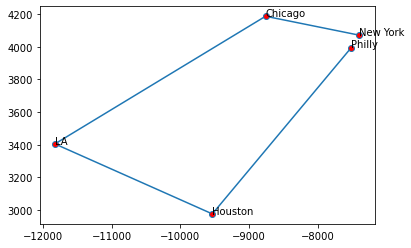

In [261]:
#Plotting
fig, ax1 = plt.subplots(ncols=1)
y=[4071,4187,3405,2976,3995]
x=[-7400,-8762,-11824,-9536,-7516]
n=['New York','Chicago',"LA","Houston","Philly"]
ax1.plot(x, y, marker="o", markerfacecolor="r")
for i, txt in enumerate(n):
    ax1.annotate(txt, (x[i], y[i]))

# Your Turn
Now write the code to calculate the ideal path for traveling the top 99 cities of U.S.

In [272]:
NewYork=City(4069, -7392)
LosAngeles=City(3411, -11841)
Chicago=City(4184, -8769)
Miami=City(2578, -8021)
Dallas=City(3279, -9677)
Philadelphia=City(4001, -7513)
Houston=City(2979, -9539)
Atlanta=City(3376, -8442)
Washington=City(3890, -7702)
Boston=City(4232, -7108)
Phoenix=City(3357, -11209)
Seattle=City(4762, -12232)
SanFrancisco=City(3776, -12244)
Detroit=City(4238, -8310)
SanDiego=City(3283, -11712)
Minneapolis=City(4496, -9327)
Tampa=City(2799, -8245)
Denver=City(3976, -10488)
Brooklyn=City(4065, -7395)
Queens=City(4075, -7380)
Riverside=City(3394, -11739)
Baltimore=City(3931, -7661)
LasVegas=City(3623, -11527)
Portland=City(4554, -12265)
SanAntonio=City(2947, -9853)
StLouis=City(3864, -9025)
Sacramento=City(3857, -12147)
Orlando=City(2848, -8134)
SanJose=City(3730, -12185)
Cleveland=City(4148, -8168)
Pittsburgh=City(4044, -7998)
Austin=City(3030, -9775)
Cincinnati=City(3914, -8451)
KansasCity=City(3912, -9455)
Manhattan=City(4078, -7397)
Indianapolis=City(3978, -8615)
Columbus=City(3999, -8299)
Charlotte=City(3521, -8083)
VirginiaBeach=City(3673, -7604)
Bronx=City(4085, -7387)
Milwaukee=City(4306, -8797)
Providence=City(4182, -7142)
Jacksonville=City(3033, -8167)
SaltLakeCity=City(4078, -11193)
Nashville=City(3617, -8678)
Richmond=City(3753, -7748)
Memphis=City(3510, -8998)
Raleigh=City(3583, -7864)
NewOrleans=City(3007, -8993)
Louisville=City(3817, -8565)
OklahomaCity=City(3547, -9751)
Bridgeport=City(4119, -7320)
Buffalo=City(4290, -7885)
FortWorth=City(3278, -9735)
Hartford=City(4177, -7268)
Tucson=City(3215, -11088)
Omaha=City(4126, -9605)
ElPaso=City(3185, -10643)
McAllen=City(2623, -9825)
Albuquerque=City(3511, -10665)
Birmingham=City(3353, -8680)
Sarasota=City(2734, -8254)
Dayton=City(3978, -8420)
Rochester=City(4317, -7762)
Fresno=City(3678, -11979)
Allentown=City(4060, -7548)
Tulsa=City(3613, -9590)
CapeCoral=City(2664, -8200)
Concord=City(3797, -12200)
ColoradoSprings=City(3887, -10476)
Charleston=City(3282, -7996)
Springfield=City(4212, -7254)
GrandRapids=City(4296, -8566)
MissionViejo=City(3361, -11766)
Albany=City(4267, -7380)
Knoxville=City(3597, -8395)
Bakersfield=City(3535, -11904)
Ogden=City(4123, -11197)
BatonRouge=City(3044, -9113)
Akron=City(4108, -8152)
NewHaven=City(4131, -7292)
Columbia=City(3404, -8090)
Mesa=City(3340, -11172)
PalmBay=City(2796, -8066)
Provo=City(4025, -11165)
Worcester=City(4227, -7181)
Murrieta=City(3357, -11719)
Greenville=City(3484, -8236)
Wichita=City(3769, -9734)
Toledo=City(4166, -8358)
StatenIsland=City(4058, -7415)
DesMoines=City(4157, -9361)
LongBeach=City(3380, -11817)
PortStLucie=City(2728, -8039)
Denton=City(3322, -9714)
Madison=City(4308, -8939)
cityList= []
cityList.append(NewYork)
cityList.append(LosAngeles)
cityList.append(Chicago)
cityList.append(Miami)
cityList.append(Dallas)
cityList.append(Philadelphia)
cityList.append(Houston)
cityList.append(Atlanta)
cityList.append(Washington)
cityList.append(Boston)
cityList.append(Phoenix)
cityList.append(Seattle)
cityList.append(SanFrancisco)
cityList.append(Detroit)
cityList.append(SanDiego)
cityList.append(Minneapolis)
cityList.append(Tampa)
cityList.append(Denver)
cityList.append(Brooklyn)
cityList.append(Queens)
cityList.append(Riverside)
cityList.append(Baltimore)
cityList.append(LasVegas)
cityList.append(Portland)
cityList.append(SanAntonio)
cityList.append(StLouis)
cityList.append(Sacramento)
cityList.append(Orlando)
cityList.append(SanJose)
cityList.append(Cleveland)
cityList.append(Pittsburgh)
cityList.append(Austin)
cityList.append(Cincinnati)
cityList.append(KansasCity)
cityList.append(Manhattan)
cityList.append(Indianapolis)
cityList.append(Columbus)
cityList.append(Charlotte)
cityList.append(VirginiaBeach)
cityList.append(Bronx)
cityList.append(Milwaukee)
cityList.append(Providence)
cityList.append(Jacksonville)
cityList.append(SaltLakeCity)
cityList.append(Nashville)
cityList.append(Richmond)
cityList.append(Memphis)
cityList.append(Raleigh)
cityList.append(NewOrleans)
cityList.append(Louisville)
cityList.append(OklahomaCity)
cityList.append(Bridgeport)
cityList.append(Buffalo)
cityList.append(FortWorth)
cityList.append(Hartford)
cityList.append(Tucson)
cityList.append(Omaha)
cityList.append(ElPaso)
cityList.append(McAllen)
cityList.append(Albuquerque)
cityList.append(Birmingham)
cityList.append(Sarasota)
cityList.append(Dayton)
cityList.append(Rochester)
cityList.append(Fresno)
cityList.append(Allentown)
cityList.append(Tulsa)
cityList.append(CapeCoral)
cityList.append(Concord)
cityList.append(ColoradoSprings)
cityList.append(Charleston)
cityList.append(Springfield)
cityList.append(GrandRapids)
cityList.append(MissionViejo)
cityList.append(Albany)
cityList.append(Knoxville)
cityList.append(Bakersfield)
cityList.append(Ogden)
cityList.append(BatonRouge)
cityList.append(Akron)
cityList.append(NewHaven)
cityList.append(Columbia)
cityList.append(Mesa)
cityList.append(PalmBay)
cityList.append(Provo)
cityList.append(Worcester)
cityList.append(Murrieta)
cityList.append(Greenville)
cityList.append(Wichita)
cityList.append(Toledo)
cityList.append(StatenIsland)
cityList.append(DesMoines)
cityList.append(LongBeach)
cityList.append(PortStLucie)
cityList.append(Denton)
cityList.append(Madison)
city_l = cityList
print(len(city_l))

96


**To-do:** (1.8) (5 points)

(1) Use GA to find an ideal traveling path. (4 points)

We recommand the following settings. Feel free to apply settings beyond the recommended values:

1. `popSize` : 200 - 1000
2. `eliteSize`: 0.1 * `popSize`
3. `mutationRate`: 0.01 - 0.05
4. `generation`: < 2000 (or computation time might take longer than an hour)
5. `max_num_gen_no_improv`: >25 

(2) Plot the best route. (1 point)

Optional: Generate an animation of the evolution of the individuals using `make_animation`.  The saved .gif file will be inside the folder where your notebook is located.


Initial distance: 162223.7313841947
Final distance: 130546.34198166487


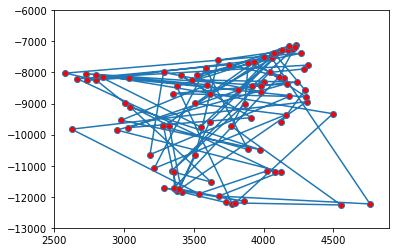

In [274]:
#YOUR CODE HERE

# For plotting:
best_route = geneticAlgorithm(cityList, 200, 20, .01, 100, 30)[0]
fig,ax = plt.subplots()
ax.set_xlim([2500,4900])
ax.set_ylim([-13000,-6000])
x=[]
for i in best_route:
    x.append(i.x)
y=[]
for i in best_route:
    y.append(i.y) 
ax.plot(x, y, marker="o", markerfacecolor="r")

In [ ]:
def make_animation(route_list,fitness_record, Name ="Your Name"):
    
    '''
    Input:  route_list : A list of routes. Its lenghth is the number of generations.
            fitness_record: A list of fitness scores. Its length is also the number of generations.
    
    '''
    
    fig,ax = plt.subplots()
    ax.set_xlim([2500,4900])
    ax.set_ylim([-13000,-6000])

    if len(route_list)<=50:
        divisor = 1 
    else:
        divisor= len(route_list)//50
    def initial():
        ax.set_xlim([2500,4900])
        ax.set_ylim([-13000,-6000])
        route_plot, = ax.plot([], [], marker="o", markerfacecolor="r")
        return route_plot,
    def update(n):
        x=[]
        if n >= (len(route_list)//divisor):
            for i in route_list[-1]:
                x.append(i.x)
            y=[]
            for i in route_list[-1]:
                y.append(i.y) 
        else:
            print(f"Producing plot for generation: {int(np.floor(n*divisor))}", end='\r')
            for i in route_list[int(np.floor(n*divisor))]:
                x.append(i.x)
            y=[]
            for i in route_list[int(np.floor(n*divisor))]:
                y.append(i.y)  

        ax = plt.axes(xlim=(2500,4900), ylim=(-13000,-6000))

        route_plot, = ax.plot(x, y, marker="o", markerfacecolor="r")
        ax.set_title(f"Solving traveling salesman problem using genetic algorithms ({Name})")
        route_plot.set_label(f"Generation: {int(np.floor(n*divisor))} Distance : {1 / fitness_record[int(np.floor(n*divisor))]}")
        ax.legend()

        return route_plot,
    anim = animation.FuncAnimation(fig, update, init_func=None, frames=int(len(route_list)//divisor), blit=True)    


    anim.save('animation.gif', fps=4, writer="avconv", codec="libx264",dpi=600)
    

### Extra credit (1.9)   (4 points): 
A greedy algorithm is an algorithm that chooses the "most attractive" option at every iteration. For the TSP, the greedy algorithm will produce a route by always appending the city that is the closest to the current city. It is a very intuitive and a fast algorithm, but it does not produce the most optimal result. Below is the code for the greedy algorithm that will produce an sub-optimal route. Your challenge is to produce a route using GA that has a shorter overall distance than the output from the greedy algorithm. Remeber that distance is the inverse of the fitness.

**To-do:**

Plot your route and its overall distance. 

In [ ]:
def greedy(cityList):
    mindist = 1E10
    minr = None
    for ind in range(len(cityList)):
        copy = cityList*1
        out = []
        out.append(copy[ind])
        copy.pop(ind)
        for i in range(len(cityList)-1):
            distances = {}
            for j in range(len(copy)):
                distances[j] = out[-1].distance(copy[j])
            s = sorted(distances.items(), key = operator.itemgetter(1), reverse = False)
            out.append(copy[s[0][0]])
            copy.pop(s[0][0])
        f = Fitness(out)
        if f.routeDistance() < mindist:
            mindist = f.routeDistance()
            mindr = f.route
    return mindist,mindr
dis,r = greedy(city_l)     
print("The shortest route distance using a greedy algorithm : ",dis)

## Conclusion
I hope this was a fun, hands-on assignment to continue with GA practice.If you want to take this to the next step try to implement a GA on another problem set; see how you would change the breed and mutate functions to handle other types of chromosomes. We’re just scratching the surface here!

## Submission
Please submit your notebook as well as its PDF copy on Gradescope. Make sure all of the outputs are clear visable in the PDF copy. 